# Zadanie5
####Proces ruiny
to termin, który opisuje sytuację, w której zasoby finansowe firmy ubezpieczeniowej stają się niewystarczające do pokrycia jej zobowiązań, prowadząc do jej bankructwa. Analiza tego procesu obejmuje badanie prawdopodobieństwa ruiny oraz dynamiki przepływów gotówkowych. Kluczowym aspektem jest modelowanie i przewidywanie przyszłych strat, aby zrozumieć i minimalizować ryzyko upadłości.

Skupimy się na modelu Cramera-Lundberga:
$$ X_t = u + ct - ∑^{N_t}_{i=0} ξ_i $$


Zmienne:

- $c$ - stopa składki

- $u$ - kapitał początkowy

- $η$ - parametr szybkości rozkładu wykładniczego $ξ_i$
  $(Eξ_i = η)$

- $λ$ - intensywność procesu Poissona $N_t$


####Model Cramera-Lundberga:

In [2]:
import math
import time
import timeit
import typing

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from scipy.special import lambertw


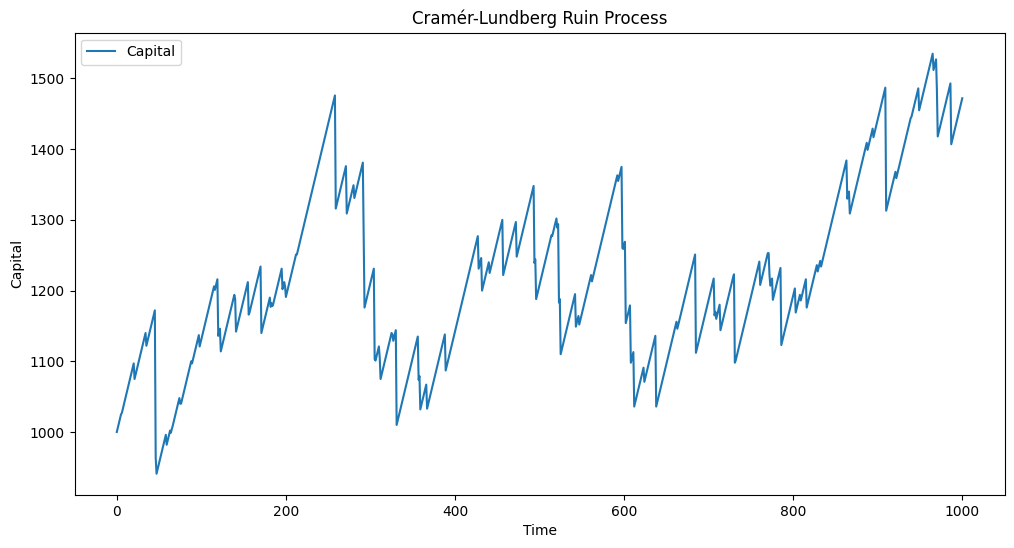

In [3]:
# Cramér-Lundberg ruin process
u = 1000  # initial capital
premium_rate = 5  # premium rate
lambd = 0.1  # rate of claims
average_claim_size = 50  # average claim size
time_horizon = 1000  # simulation time

# Generate random events related to claims
np.random.seed(42)
num_claims = np.random.poisson(lambd * time_horizon)
claim_times = np.random.uniform(0, time_horizon, num_claims)
claim_sizes = np.random.exponential(average_claim_size, num_claims)

# Sort claim events by time
sorted_indices = np.argsort(claim_times)
claim_times = claim_times[sorted_indices]
claim_sizes = claim_sizes[sorted_indices]

# Ruin process
time_points = np.arange(0, time_horizon + 1, 1)
capital = np.zeros_like(time_points)
capital[0] = u

claim_index = 0
for t in range(1, len(time_points)):
    capital[t] = capital[t - 1] + premium_rate
    if claim_index < num_claims and claim_times[claim_index] <= time_points[t]:
        capital[t] -= claim_sizes[claim_index]
        claim_index += 1

# Plot
plt.figure(figsize=(12, 6))
plt.plot(time_points, capital, label='Capital')
plt.xlabel('Time')
plt.ylabel('Capital')
plt.title('Cramér-Lundberg Ruin Process')
plt.legend()
plt.show()


Funkcje prawdopodobieństwa ruiny, dla różnych wartości $c$ i różnych wartości $u$.

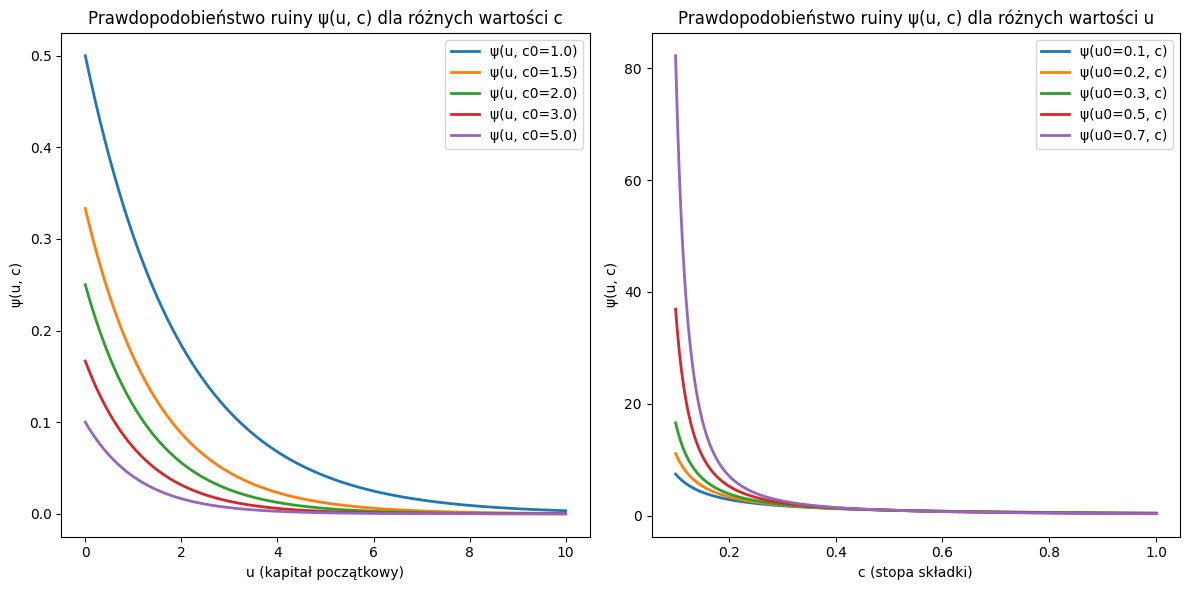

In [4]:
eta = 1.0
lambd = 0.5

# Funkcja prawdopodobieństawa ruiny
def psi(u: float, c: float, eta: float = 1.0, lambd: float= 0.5) -> float:
    """
    Calculates the ruin probability in the Cramér-Lundberg model.

    Parameters:
    u (float): Initial capital (u ≥ 0)
    c (float): Premium rate (c > 0)
    eta (float): Rate parameter of the exponential distribution of ξ_i (η > 0)
    lambd (float): Intensity of the Poisson process N_t (λ > 0)

    Returns:
    float: Ruin probability ψ(u, c)

    Example usage:
    >>> psi(10, 1.0, 1.0, 0.5)
    0.01831563888873418
    """
    # Calculate the ruin probability
    return (eta * lambd / c) * np.exp(-(1 - lambd / (c * eta)) * u)

# u and c values
u_values = np.linspace(0, 10, 400)  # Zwiększony zakres dla u do 20
c_values = np.linspace(0.1, 1, 400)

# u_0 and c_0 fixed values
c_values_fixed = [1.0, 1.5, 2.0, 3.0, 5.0]
u_values_fixed = [0.1, 0.2, 0.3, 0.5, 0.7]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# ψ(u, c) for fixed c
for c0 in c_values_fixed:
    psi_u_c0 = psi(u_values, c0, eta, lambd)
    axes[0].plot(u_values, psi_u_c0, label=f'ψ(u, c0={c0})', linewidth=2)

axes[0].set_title('Prawdopodobieństwo ruiny ψ(u, c) dla różnych wartości c')
axes[0].set_xlabel('u (kapitał początkowy)')
axes[0].set_ylabel('ψ(u, c)')
axes[0].legend()

# dla ψ(u, c) for fixed u
for u0 in u_values_fixed:
    psi_u0_c = psi(u0, c_values, eta, lambd)
    axes[1].plot(c_values, psi_u0_c, label=f'ψ(u0={u0}, c)', linewidth=2)

axes[1].set_title('Prawdopodobieństwo ruiny ψ(u, c) dla różnych wartości u')
axes[1].set_xlabel('c (stopa składki)')
axes[1].set_ylabel('ψ(u, c)')
axes[1].legend()

plt.tight_layout()
plt.show()


Wykres dla funkcji odwrotnej.

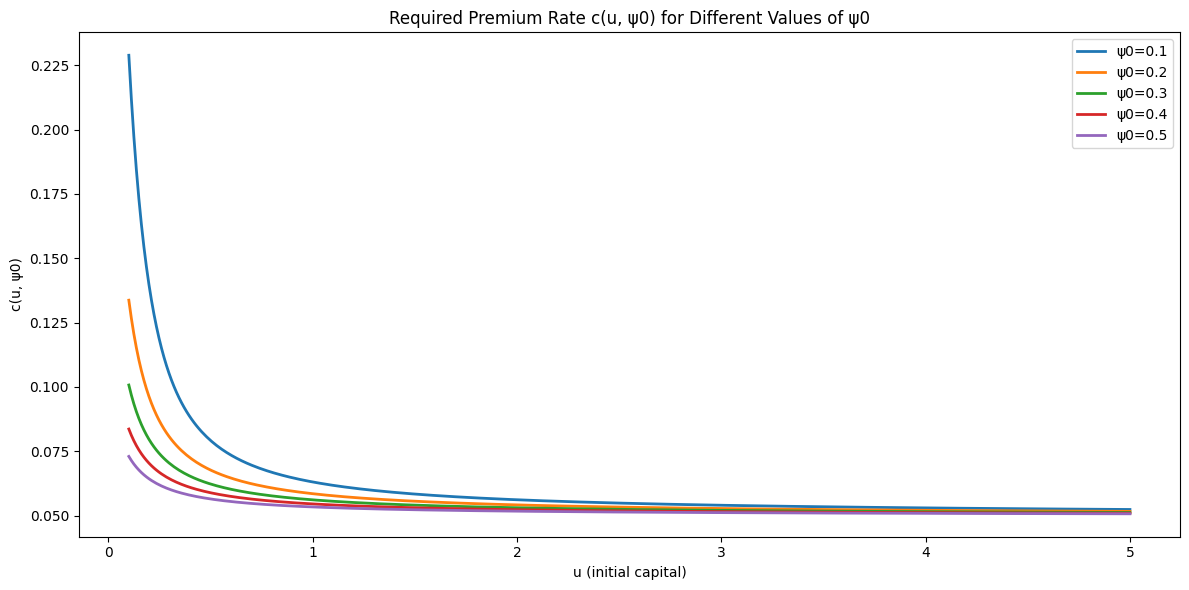

In [7]:

# Inverse ruin probability function
def c_inverse(u: float, psi0: float, eta: float =0.1, lambd: float =0.5) -> float:
    """
    Calculates the required premium rate c for given initial capital u and ruin probability ψ0.

    Parameters:
    u (float): Initial capital (u ≥ 0)
    psi0 (float): Desired ruin probability (0 < ψ0 < 1)
    eta (float): Rate parameter of the exponential distribution of ξ_i (η > 0)
    lambd (float): Intensity of the Poisson process N_t (λ > 0)

    Returns:
    float: Required premium rate c(u, ψ0)

    Example usage:
    >>> c_inverse(10, 0.3)
    1.4753940640684104

    """
    # Calculate the required premium rate
    return (lambd * u) / np.real(lambertw((psi0 * u * np.exp(u / eta)) / eta))

# u values
u_values = np.linspace(0.1, 5, 400)  # Range of u values

# Fixed psi0 values
psi0_values_fixed = [0.1, 0.2, 0.3, 0.4, 0.5]

# Plotting
plt.figure(figsize=(12, 6))

# ψ(u, c) for fixed ψ0
for psi0 in psi0_values_fixed:
    c_u_psi0 = [c_inverse(u, psi0, eta, lambd) for u in u_values]
    plt.plot(u_values, c_u_psi0, label=f'ψ0={psi0}', linewidth=2)

plt.title('Required Premium Rate c(u, ψ0) for Different Values of ψ0')
plt.xlabel('u (initial capital)')
plt.ylabel('c(u, ψ0)')
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
#  Generating a sample of data from a normal distribution
np.random.seed(0)
sample_data = np.random.normal(0, 1, 1000)

# Kolmogorov-Smirnov test for goodness of fit to a normal distribution
statistic, p_value = stats.kstest(sample_data, 'norm')

print(f"KS Statistic: {statistic}")
print(f"P-value: {p_value}")


KS Statistic: 0.03737519429804048
P-value: 0.11930823166569182


### Wnioski
Do określenia istotności statystycznej używa się progu wartości p 0.05. W tym przypadku, wartość p wynosząca około 0.1193 jest większa niż 0.05.
Ponieważ wartość p jest większa niż 0.05, nie mamy podstaw do odrzucenia hipotezy zerowej. Oznacza to, że nie ma wystarczających dowodów, aby stwierdzić, że dane próbki nie pochodzą z rozkładu normalnego.

Test Kołmogorowa-Smirnowa wskazuje, że dane próbki wygenerowane z rozkładu normalnego nie odbiegają istotnie od oczekiwanego rozkładu normalnego, co potwierdzają wartości statystyki KS i wartości p. W konsekwencji możemy przyjąć, że dane próbki pochodzą z rozkładu normalnego.